In [ ]:
!pip install transformers

In [ ]:
import torch
import re
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim import AdamW
from transformers import Trainer, TrainingArguments
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# This is the name of the program management system for NVIDIA GPUs. We're going to send our code here.
device_name = 'cuda'

In [ ]:
# t5
generator = pipeline(task="text2text-generation", model="t5-base", tokenizer="t5-base")
# Example input text
input_text = "Harry and Hermione play near the school"

# Generate text using T5
generated_text = generator(input_text, max_length=50, do_sample=True)

# Print the generated text
print("Generated text:", generated_text[0]['generated_text'])


/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Generated text: with Hermione, along with Harry and Hermione play near the school. Harry and Hermione get together after school, as do Hermione and Harry play beside the school.


In [ ]:
#Data Loading and Data Cleaning
script_files = [
                "/kaggle/input/books-dataset-text-generation/Book 1.txt",
                "/kaggle/input/books-dataset-text-generation/Book 2.txt",
                "/kaggle/input/books-dataset-text-generation/Book 3.txt",
                "/kaggle/input/books-dataset-text-generation/Book 4.txt",
                "/kaggle/input/books-dataset-text-generation/Book 5.txt",
                "/kaggle/input/books-dataset-text-generation/Book 6.txt",
                "/kaggle/input/books-dataset-text-generation/Book 7.txt"
                ]
text_data=""
for script in script_files:
    with open(script, 'r', encoding='utf-8') as file:
        text = file.read()
        text = re.sub(r"[^\w\s]", "", text)
        text = re.sub(r"\s+", " ", text)
        text_data=text_data+text
        text_data = text_data.strip()
        file.close()
#Save cleaned data in a text file
data_file = open('/kaggle/working/cleaned_text_data.txt', 'w')
data_file.write(text_data)
data_file.close()

In [ ]:
#Location of cleaned data
data_file= '/kaggle/working/cleaned_text_data.txt'

In [ ]:
#Size of text data
len(text_data)

6182371

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
#Tokenize the dataset
dataset = TextDataset(tokenizer=tokenizer,file_path=data_file,block_size=128)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,mlm=False)

/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:220: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes 

## Define Required Functions

In [ ]:
#Define function to load and tokenize the dataset
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset

#Function to load data collator for language modelling
def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm,
    )
    return data_collator

#Function to train the model
def train(train_file_path,model_name,output_dir,overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,learning_rate):

    tokenizer = T5Tokenizer.from_pretrained("t5-base")
    train_dataset = load_dataset(train_file_path, tokenizer)
    data_collator = load_data_collator(tokenizer)

    tokenizer.save_pretrained(output_dir)

    model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device_name)

    #Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,logging_steps=100, learning_rate = learning_rate)
    #Trainer function to train the model
    trainer = Trainer(model=model,args=training_args,data_collator=data_collator,train_dataset=train_dataset)

    trainer.train()
    #Save the model
    trainer.save_model()
    return trainer



### Fine tune GPT-2 model with learning rate 0.0001 (Model 1)

In [ ]:
#Setting parameters
train_file_path = data_file
model_name = 't5'
output_dir = 'saved_model'
overwrite_output_dir = True
per_device_train_batch_size = 32
num_train_epochs = 2
learning_rate = 0.0001

In [ ]:
#Calling train function to train the model
print("Learning Rate = ", learning_rate)
trainer = train(train_file_path=train_file_path,model_name=model_name,
                output_dir=output_dir,
                overwrite_output_dir=overwrite_output_dir,
                per_device_train_batch_size=per_device_train_batch_size,
                num_train_epochs=num_train_epochs, learning_rate=learning_rate)

Learning Rate =  0.0001


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
100,0.158500
200,0.004200
300,0.002600
400,0.002200
500,0.001700
600,0.001600
700,0.001400


### Visualize the training logs for Model 1

In [ ]:
#Print the model training logs
trainer.state.log_history

[{'loss': 0.1585,
  'learning_rate': 8.65951742627346e-05,
  'epoch': 0.27,
  'step': 100},
 {'loss': 0.0042,
  'learning_rate': 7.319034852546918e-05,
  'epoch': 0.54,
  'step': 200},
 {'loss': 0.0026,
  'learning_rate': 5.978552278820375e-05,
  'epoch': 0.8,
  'step': 300},
 {'loss': 0.0022,
  'learning_rate': 4.638069705093834e-05,
  'epoch': 1.07,
  'step': 400},
 {'loss': 0.0017,
  'learning_rate': 3.297587131367292e-05,
  'epoch': 1.34,
  'step': 500},
 {'loss': 0.0016,
  'learning_rate': 1.9571045576407505e-05,
  'epoch': 1.61,
  'step': 600},
 {'loss': 0.0014,
  'learning_rate': 6.1662198391420915e-06,
  'epoch': 1.88,
  'step': 700},
 {'train_runtime': 774.9704,
  'train_samples_per_second': 30.793,
  'train_steps_per_second': 0.963,
  'total_flos': 3633042775080960.0,
  'train_loss': 0.023159460401806692,
  'epoch': 2.0,
  'step': 746}]

In [ ]:
#Store steps, loss and epochs data from training logs
steps = []
loss =[]
epochs=[]
for i in range(len(trainer.state.log_history)):
    steps.append(trainer.state.log_history[i]["step"])
for i in range(len(trainer.state.log_history)):
    epochs.append(trainer.state.log_history[i]["epoch"])


In [ ]:
for i in range(len(trainer.state.log_history)-1):
    loss.append(trainer.state.log_history[i]["loss"])
loss.append(trainer.state.log_history[len(trainer.state.log_history)-1]["train_loss"])

In [ ]:
print(epochs,steps, loss)

[0.27, 0.54, 0.8, 1.07, 1.34, 1.61, 1.88, 2.0] [100, 200, 300, 400, 500, 600, 700, 746] [0.1585, 0.0042, 0.0026, 0.0022, 0.0017, 0.0016, 0.0014, 0.023159460401806692]


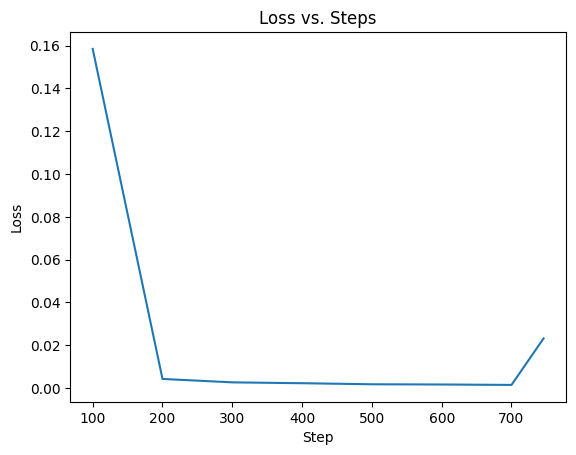

In [ ]:
#Plot the graph of training loss vs steps
plt.plot(steps, loss)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss vs. Steps")
plt.show()

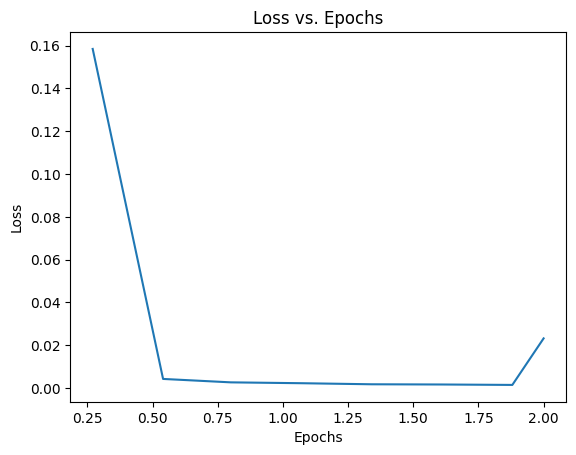

In [ ]:
#Plot the graph of training loss vs epochs
plt.plot(epochs, loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.show()

### Model Evaluation (Model 1)

In [ ]:
# t5
generator = pipeline(task="text2text-generation", model="./saved_model", tokenizer="t5-base")
# Example input text
input_text = "Harry and Hermione play near the school"

# Generate text using T5
generated_text = generator(input_text, max_length=50, do_sample=True)

# Print the generated text
print("Generated text:", generated_text[0]['generated_text'])


/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Generated text: Harry and Hermione play near the school while Harry and Hermione play near the school. Harry and Hermione play near the school. Harry and Hermione play near the school. Harry and Hermi


In [ ]:
#Generate text example
generator("Hogwarts", max_length=100, num_return_sequences=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hogwarts had turned into a ghost town Page 83 Harry Potter and the Philosophers Stone JK Rowling The Quidditch match had now reached its zenith at last As Snape pulled out a potion he looked like a giant frog while Crabbe and Goyle looked as ridiculous as the giant rat He seemed to have forgotten that the referee hadnt looked at him at all He was so busy with his drills that he was looking at Harry nervously as though he was trying to catch the broomstick But'}]